# Municipal Bond Price/Yield Analysis Across Quantities
Written by Gil on Jan 22, 2025

This notebook analyzes municipal bond pricing and yield behavior across different quantities for both bid and offer sides. It makes a single API call to FICC's pricing service to get pricing data for a range of quantities (10-1000) and visualizes:

1. How prices change with quantity for both bid and offer sides
2. How yields change with quantity for both bid and offer sides

This analysis helps understand:
- Price/yield sensitivity to trade size
- Bid-offer spreads at different quantity levels
- Market depth and liquidity characteristics for a given CUSIP

**Usage:**
- Input: Single CUSIP
- Output: 
  - Two graphs (price and yield)
  - DataFrame with detailed data for both sides

**Dependencies:**
- api credentials
- Google Cloud credentials (creds.json)

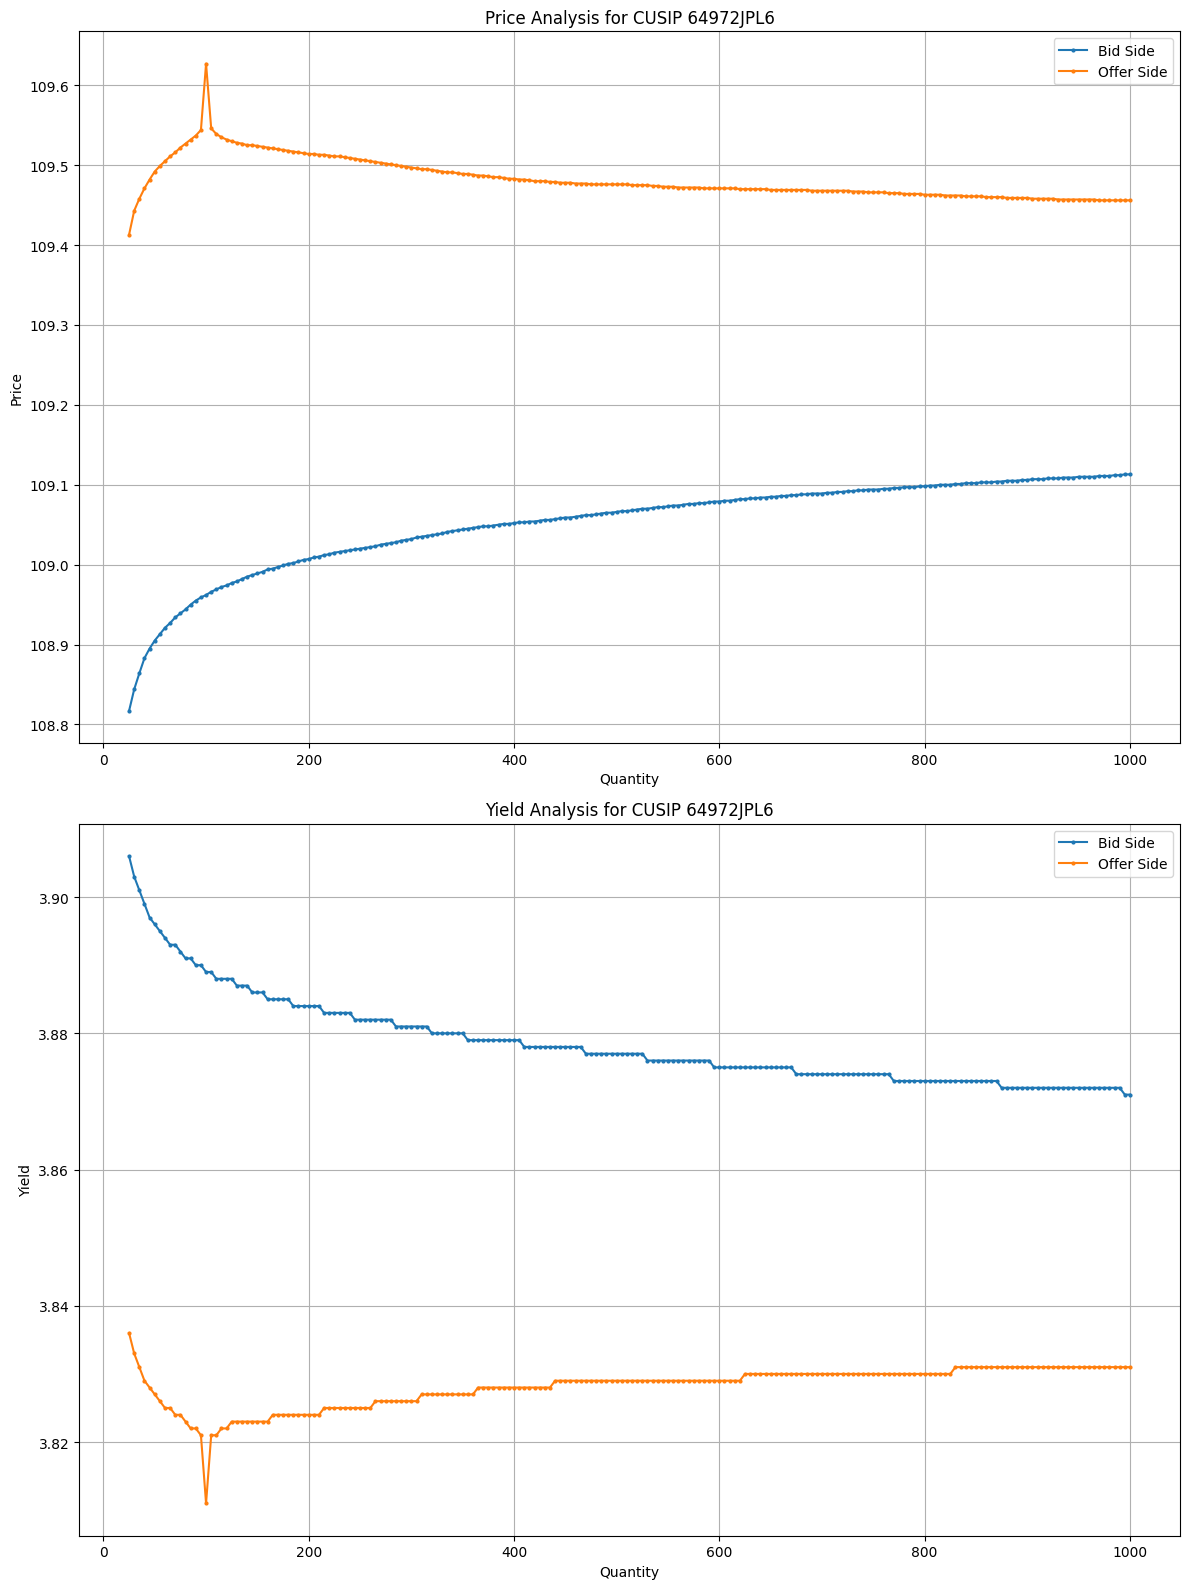

,Quantity,Bid_Side_Price,Offer_Side_Price,Bid_Side_Yield,Offer_Side_Yield
0,25,108.817,109.413,3.906,3.836
1,30,108.844,109.443,3.903,3.833
2,35,108.864,109.458,3.901,3.831
3,40,108.883,109.471,3.899,3.829
4,45,108.895,109.482,3.897,3.828
...,...,...,...,...,...
191,980,109.111,109.456,3.872,3.831
192,985,109.112,109.456,3.872,3.831
193,990,109.112,109.456,3.872,3.831
194,995,109.113,109.456,3.871,3.831


In [4]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Set Google credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/gil/git/ficc/creds.json'

# API credentials
EMAIL = 'insert email here'
PASSWORD = 'insert password here'

def analyze_cusip_pricing(cusip):
    """Analyze pricing and yields across quantities for bid and offer sides."""
    # Generate quantities from 10 to 1000
    quantities = list(range(25, 1001, 5))  # Step of 10 for better visualization
    
    # Create combinations for bid and offer sides
    cusips_quantities_tradetypes = []
    for quantity in quantities:
        # Add bid side (Purchase from Customer)
        cusips_quantities_tradetypes.append({
            'CUSIP': cusip,
            'Quantity': quantity,
            'Trade Type': 'P'
        })
        # Add offer side (Sale to Customer)
        cusips_quantities_tradetypes.append({
            'CUSIP': cusip,
            'Quantity': quantity,
            'Trade Type': 'S'
        })
    
    # Make single API call
    url = 'https://api.ficc.ai/api/batchpricing'
    data = {
        'username': EMAIL,
        'password': PASSWORD,
        'cusipList': [item['CUSIP'] for item in cusips_quantities_tradetypes],
        'quantityList': [item['Quantity'] for item in cusips_quantities_tradetypes],
        'tradeTypeList': [item['Trade Type'] for item in cusips_quantities_tradetypes]
    }
    
    response = requests.post(url, data=data)
    if not response.ok:
        print("API call failed")
        return None
    
    # Process response
    df = pd.read_json(response.json())
    
    # Split data into bid and offer
    bid_data = df[::2]  # Every other row starting from 0
    offer_data = df[1::2]  # Every other row starting from 1
    
    # Create the plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    # Price plot
    ax1.plot(quantities, bid_data['price'].values, 
            label='Bid Side', 
            marker='o', 
            markersize=2)
    ax1.plot(quantities, offer_data['price'].values, 
            label='Offer Side', 
            marker='o', 
            markersize=2)
    
    ax1.set_title(f'Price Analysis for CUSIP {cusip}')
    ax1.set_xlabel('Quantity')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Yield plot
    ax2.plot(quantities, bid_data['ytw'].values, 
            label='Bid Side', 
            marker='o', 
            markersize=2)
    ax2.plot(quantities, offer_data['ytw'].values, 
            label='Offer Side', 
            marker='o', 
            markersize=2)
    
    ax2.set_title(f'Yield Analysis for CUSIP {cusip}')
    ax2.set_xlabel('Quantity')
    ax2.set_ylabel('Yield')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Quantity': quantities,
        'Bid_Side_Price': bid_data['price'].values,
        'Offer_Side_Price': offer_data['price'].values,
        'Bid_Side_Yield': bid_data['ytw'].values,
        'Offer_Side_Yield': offer_data['ytw'].values
    })
    
    return results_df

# Example usage
cusip = '64972JPL6'  # Example CUSIP
results_df = analyze_cusip_pricing(cusip)
display(results_df)  # Show the results in notebook